# Capstone Project: Books recommender system

### Overall Contents:
- Background
- Data Collection
- Data Cleaning Books Interactions
- Data Cleaning Booklist
- Exploratory Data Analysis
* Non-personalized recommendation
    - Modeling 1 Popularity-based and Content-based recommendation system 
* Personalized recommendation
    - Modeling 2 Collaborative-filtering-based recommendation system
    - [Modeling 3 Clustering-Collaborative-filtering-based recommendation system](##-8.-Modeling-3-Clustering-Collborative-filtering-based-recommendation-system) <br>**(In this notebook)** 
    - Modeling 4 Model-based recommendation systems
- Evaluation
- Conclusion and Recommendation

### Datasets

The dataset are obtained from [University of California San Diego Book Graph](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home?authuser=0).

The dataset below, which is user-book interactions and reference will be used for recommender system.

User-book interactions:-
* user_work_interactions
* user_work_interactions_model
* user_work_interactions_sample
* genrebook_interactions

Reference:-
* booklist_worktitle
* booklist_url

For more details on the datasets, please refer to the data_dictionary_model.ipynb.

## 8. Modeling 3 Clustering-Collaborative-filtering based recommendation system

We will be performing the k-means clustering to cluster the datasets according to similar genres with the use of genrebook_interactions datasets. We will then select a cluster to perform collaborative filtering based recommendation system.

### 8.1 Libraries Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plot_graphs import dataframe_plot
from book_recommender import user_collaborative_filtering_cosine, item_collaborative_filtering_cosine, coverage, ratings_rmse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from numpy import count_nonzero
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

# Maximum display of column;s
pd.options.display.max_colwidth = 2000
pd.options.display.max_rows = 2000

### 8.2 Data Import

In [2]:
genrebook_interactions = pd.read_parquet("../data/genrebook_interactions_model.parquet")
userbook_interactions = pd.read_parquet("../data/user_work_interactions_clean.parquet")

### 8.3 K-means clustering

To obtain the optimal k-means cluster number, we will be using a subset fraction of the datasets. We then applied the k-means clustering with the optimal k-cluster number on the full datasets.

### 8.3.1 Defining the clusters number

In [3]:
genrebook_interactions.head()

,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult
work_id,,,,,,,,,,
115,3340.0,NaN,NaN,3046.0,486.0,NaN,NaN,NaN,NaN,1774.0
314,NaN,NaN,NaN,NaN,13.0,NaN,51.0,NaN,NaN,NaN
4417,NaN,NaN,NaN,69.0,NaN,NaN,NaN,NaN,NaN,NaN
4756,NaN,5.0,NaN,2.0,39.0,NaN,38.0,NaN,NaN,NaN
5064,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN


In [4]:
genrebook_interactions.shape

(1117435, 10)

In [5]:
# Obtain a fraction to perform k-means clustering for defining clusters number
first_subset = genrebook_interactions.sample(frac=0.1, random_state = 39, replace = False)
print(f"The first_subset shape is ", first_subset.shape)
first_subset = first_subset.fillna(0)

The first_subset shape is  (111744, 10)


In [6]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize dataframe.
first_subset_sc = ss.fit_transform(first_subset.T)

# Transpose the dataframe
first_subset_sc = np.transpose(first_subset_sc)

In [7]:
# K-mean clustering
scores = []
for k in tqdm(range(2, 20)):
    cl = KMeans(n_clusters=k, init='k-means++')
    cl.fit(first_subset_sc)
    inertia = cl.inertia_
    sil = silhouette_score(first_subset_sc, cl.labels_)
    scores.append([k, inertia, sil])

score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

100%|██████████| 18/18 [46:06<00:00, 153.70s/it]


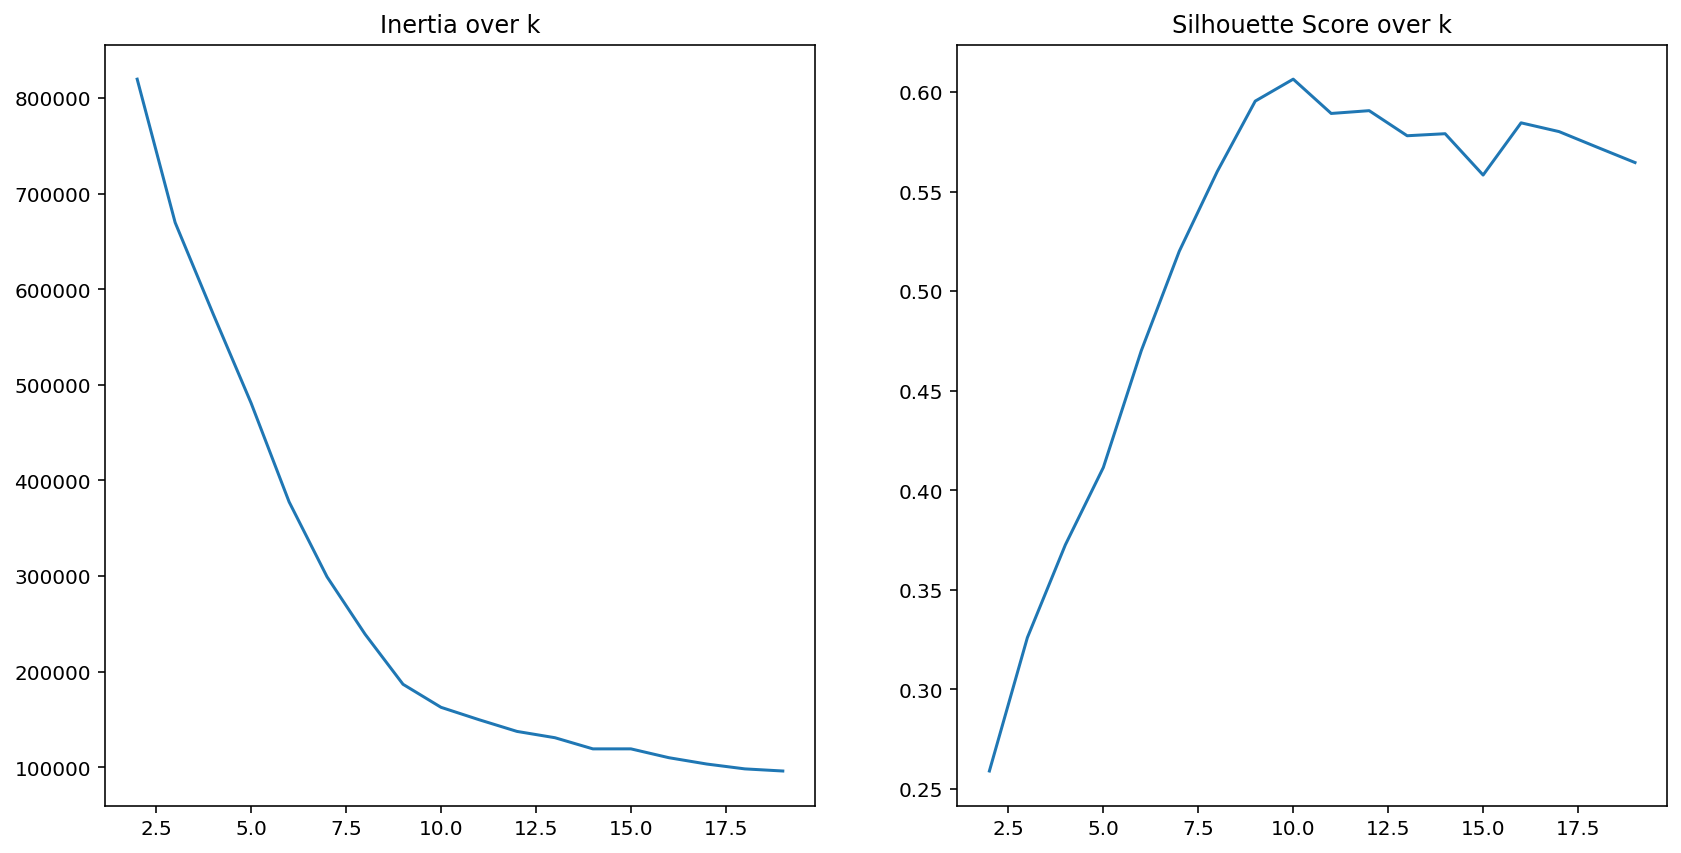

In [8]:
# Plot the inertia and silhouette score over k
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k');

In [9]:
score_df

,k,inertia,silhouette
0,2,819771.686286,0.258926
1,3,669759.233218,0.325945
2,4,574238.101183,0.372544
3,5,480950.825683,0.411397
4,6,377670.856901,0.470105
5,7,299187.607656,0.520045
6,8,239273.275430,0.560092
7,9,186848.544719,0.595457
8,10,162760.752979,0.606485
9,11,149809.446845,0.589249


**Analysis: The best silhouette score is 0.606642 when k is 10.**

The silhouette score of 0.6 signifies a moderate separation of the books into clusters.

### 8.4.2 K-means clustering on the full dataset

In [10]:
# Perform k-means clustering on the full dataset when k is 10
kmeans = KMeans(n_clusters=10, init='k-means++', random_state = 39)
genrebook_interactions = genrebook_interactions.fillna(0)

In [11]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize dataframe.
genrebook_interactions_sc = ss.fit_transform(genrebook_interactions.T)

# Transpose the dataframe
genrebook_interactions_sc = np.transpose(genrebook_interactions_sc)

In [12]:
# Fit and predict the genrebook_interactions
kmeans.fit(genrebook_interactions_sc)
kmeans.predict(genrebook_interactions_sc)

array([4, 6, 1, ..., 0, 6, 1])

In [13]:
genrebook_interactions['cluster'] = kmeans.labels_
genrebook_interactions.head()

,children,"comics, graphic","fantasy, paranormal",fiction,"history, historical fiction, biography","mystery, thriller, crime",non-fiction,poetry,romance,young-adult,cluster
work_id,,,,,,,,,,,
115,3340.0,0.0,0.0,3046.0,486.0,0.0,0.0,0.0,0.0,1774.0,4
314,0.0,0.0,0.0,0.0,13.0,0.0,51.0,0.0,0.0,0.0,6
4417,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4756,0.0,5.0,0.0,2.0,39.0,0.0,38.0,0.0,0.0,0.0,0
5064,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0,0.0,6


### 8.4.2.1 Plotting the different clusters

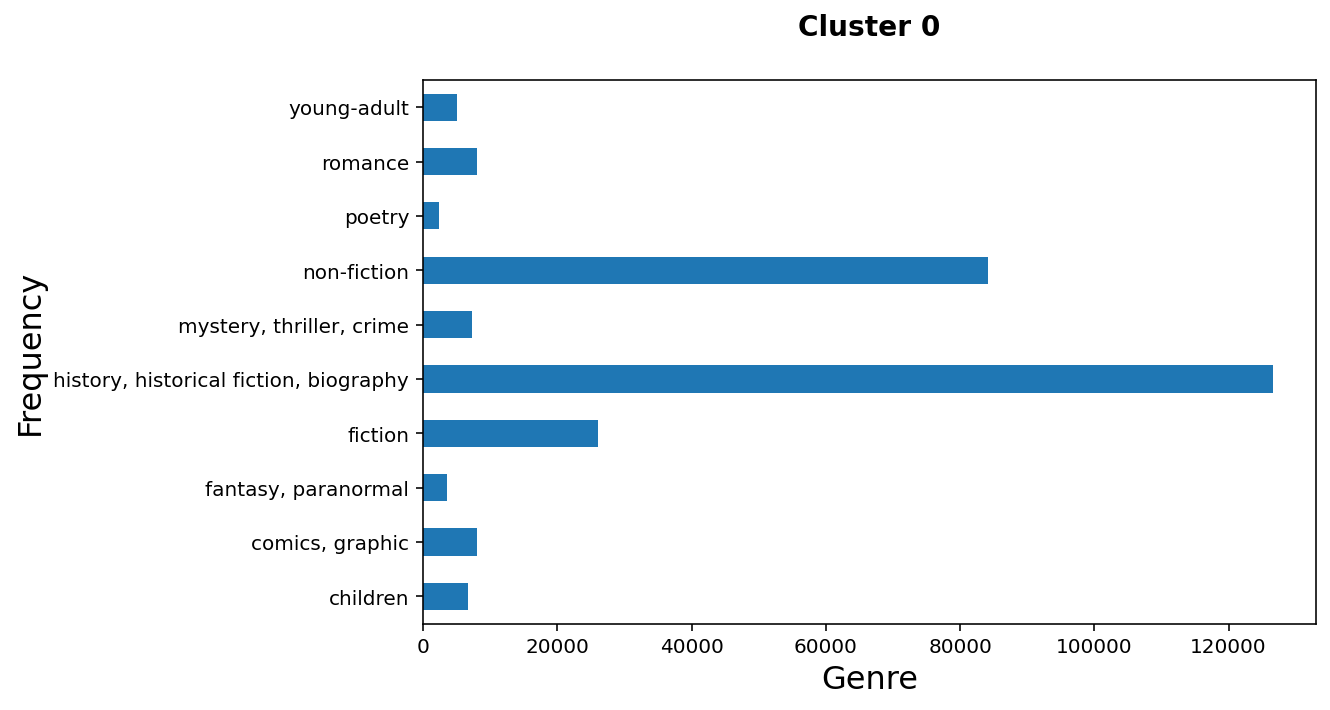

In [14]:
cluster0 = genrebook_interactions[genrebook_interactions.cluster == 0]
cluster0_plot = cluster0.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster0_plot.count(), 'barh', "Cluster 0", "Genre", "Frequency")

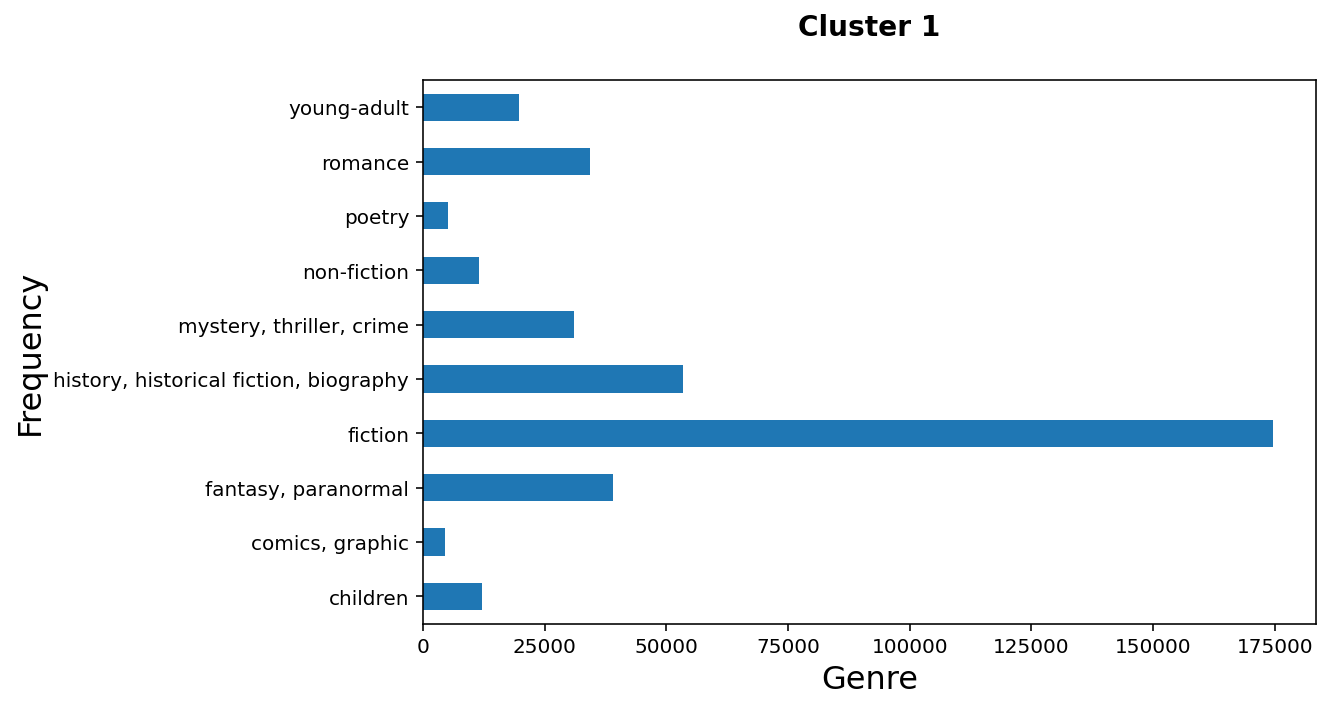

In [15]:
cluster1 = genrebook_interactions[genrebook_interactions.cluster == 1]
cluster1_plot = cluster1.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster1_plot.count(), 'barh', "Cluster 1", "Genre", "Frequency")

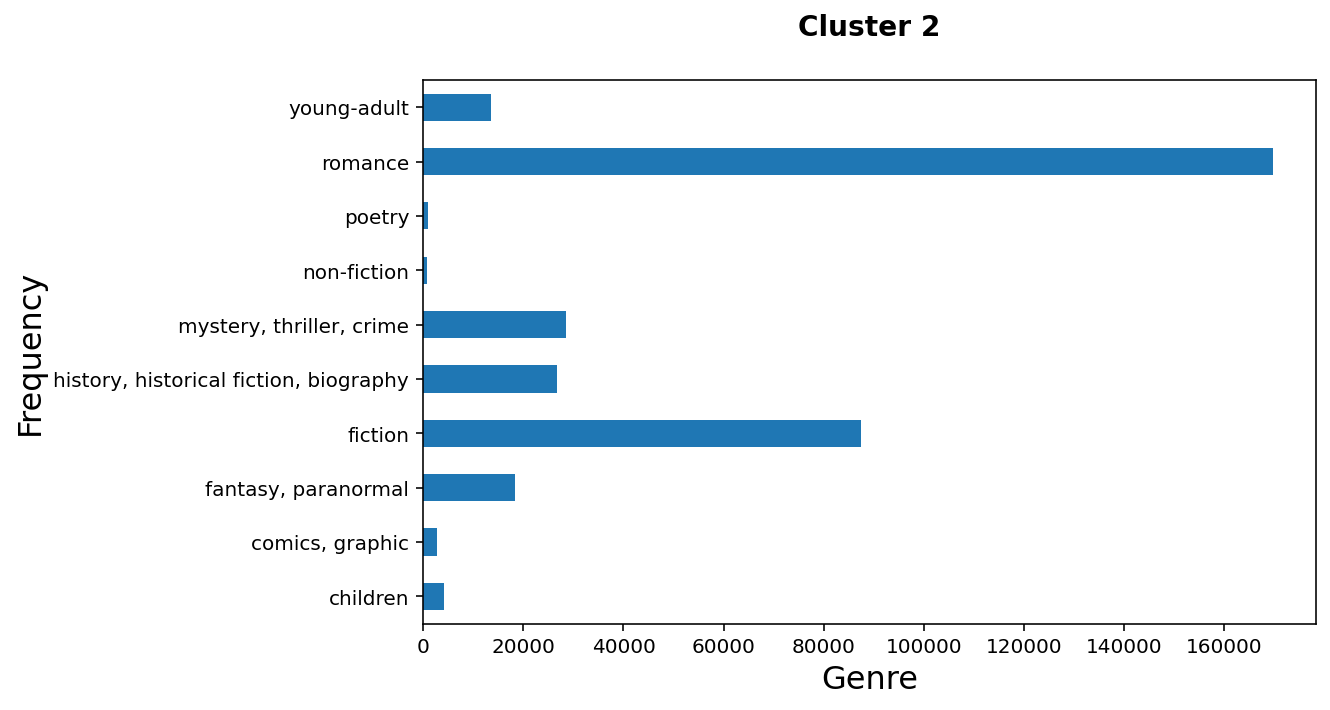

In [16]:
cluster2 = genrebook_interactions[genrebook_interactions.cluster == 2]
cluster2_plot = cluster2.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster2_plot.count(), 'barh', "Cluster 2", "Genre", "Frequency")

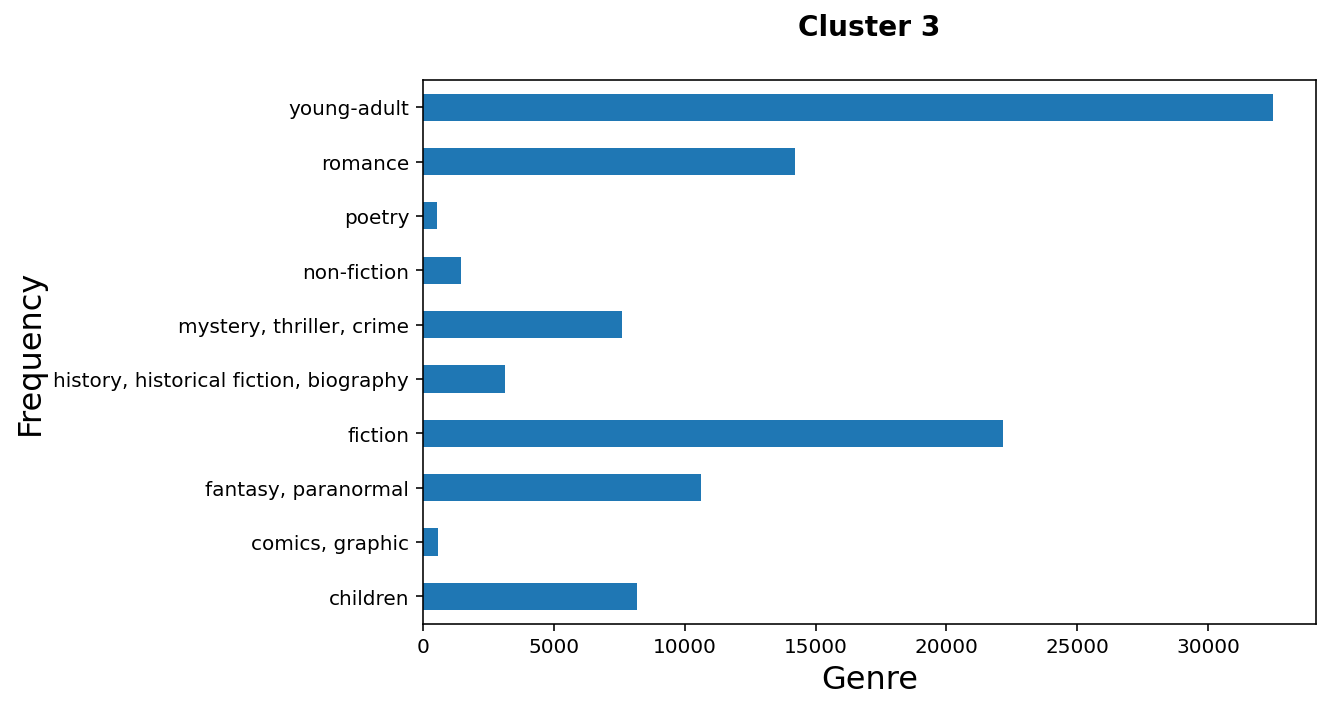

In [17]:
cluster3 = genrebook_interactions[genrebook_interactions.cluster == 3]
cluster3_plot = cluster3.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster3_plot.count(), 'barh', "Cluster 3", "Genre", "Frequency")

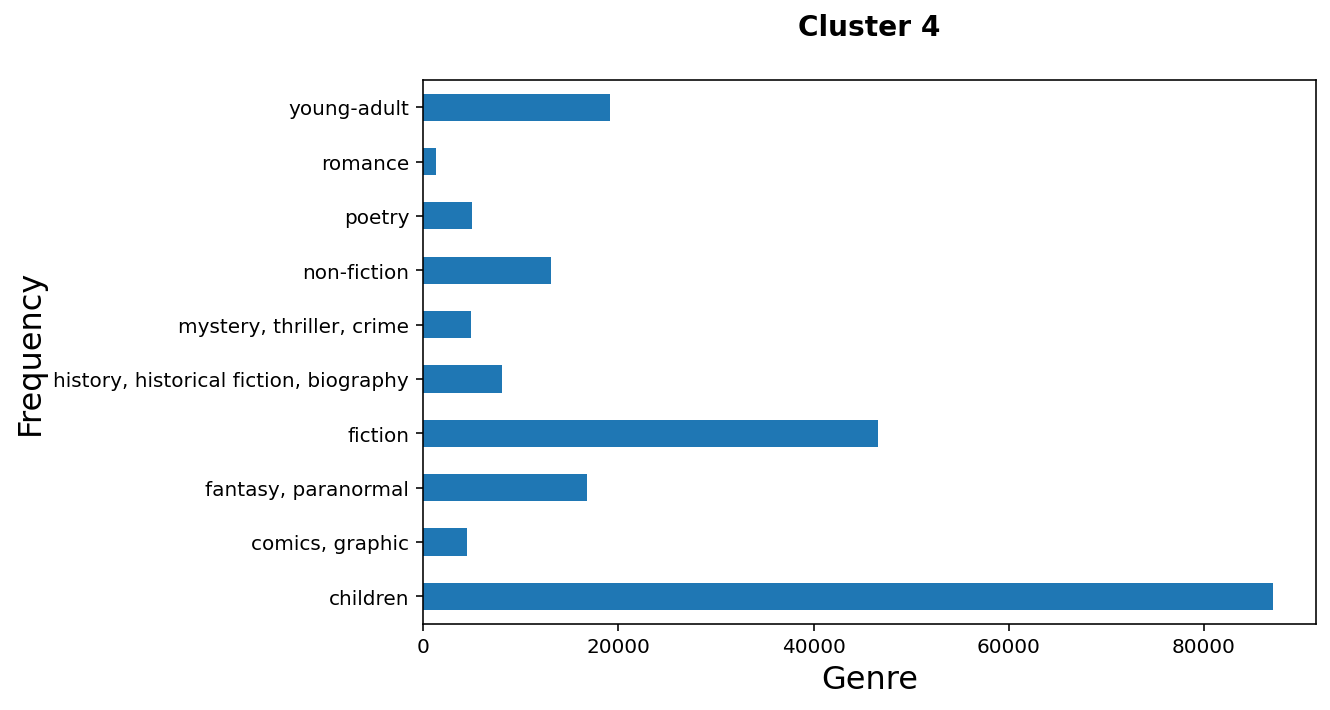

In [18]:
cluster4 = genrebook_interactions[genrebook_interactions.cluster == 4]
cluster4_plot = cluster4.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster4_plot.count(), 'barh', "Cluster 4", "Genre", "Frequency")

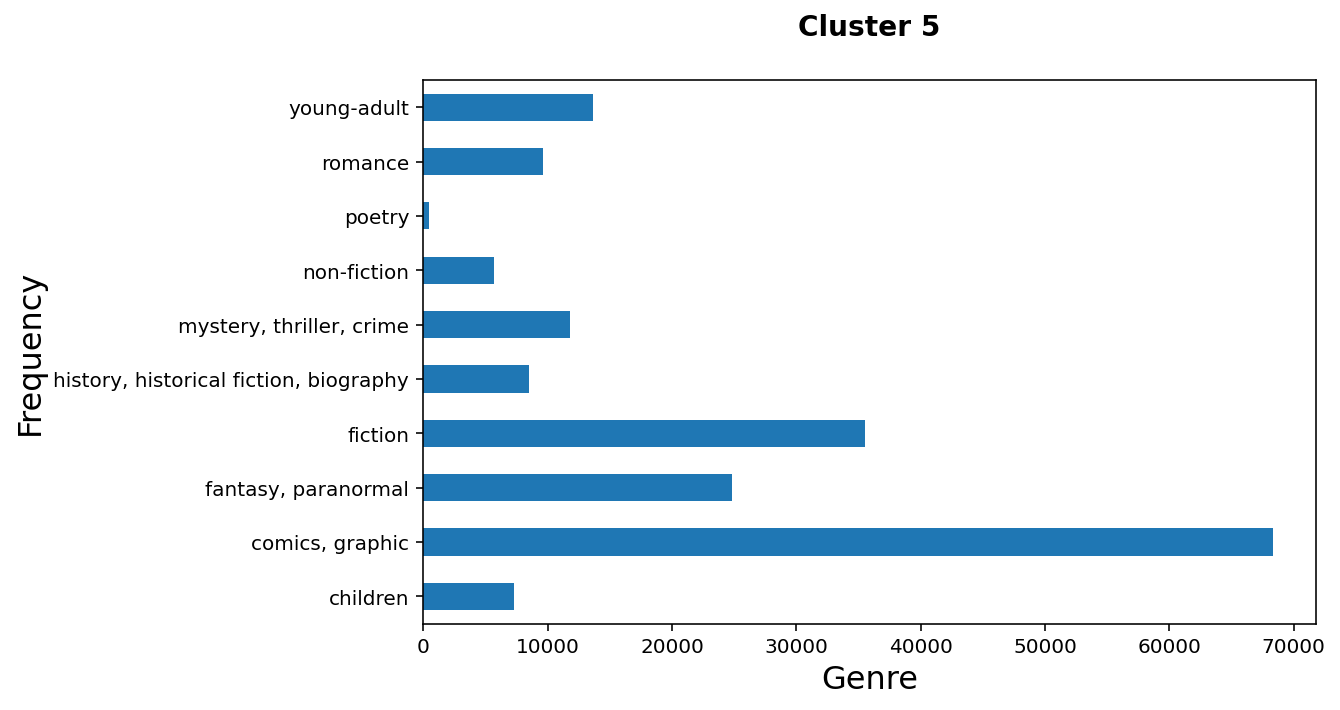

In [19]:
cluster5 = genrebook_interactions[genrebook_interactions.cluster == 5]
cluster5_plot = cluster5.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster5_plot.count(), 'barh', "Cluster 5", "Genre", "Frequency")

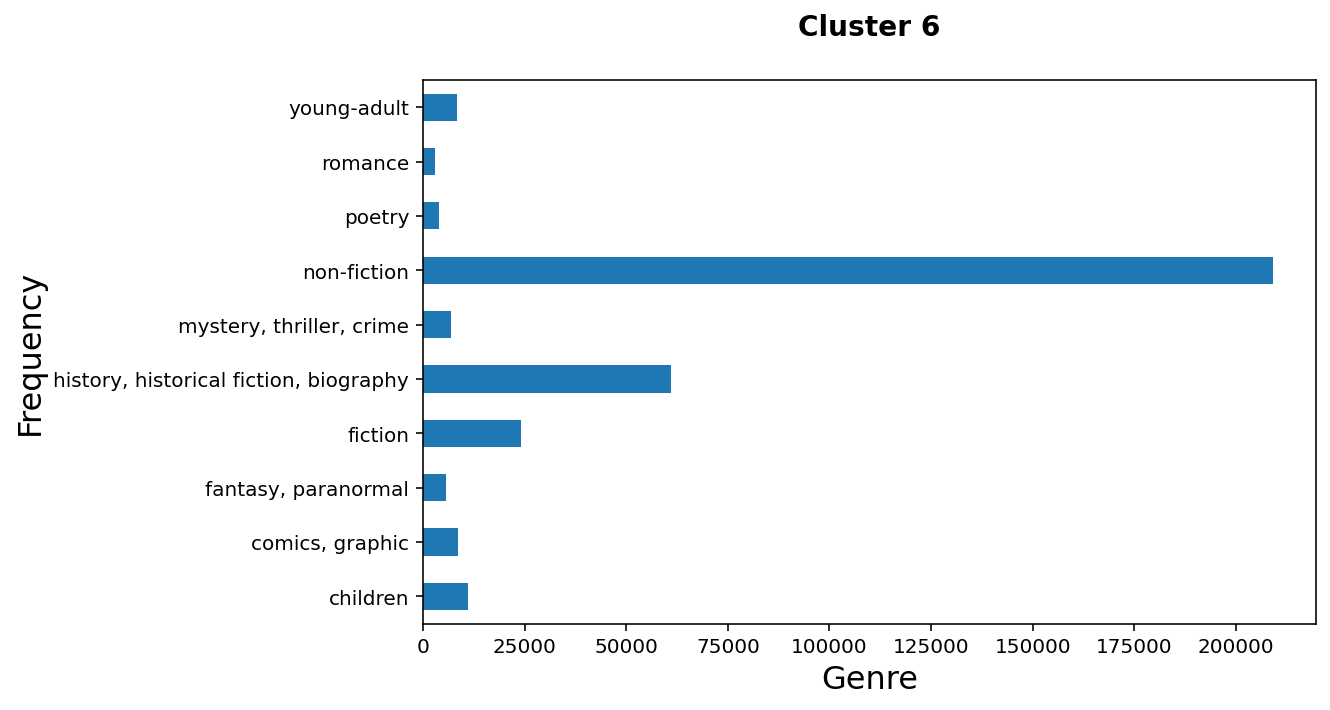

In [20]:
cluster6 = genrebook_interactions[genrebook_interactions.cluster == 6]
cluster6_plot = cluster6.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster6_plot.count(), 'barh', "Cluster 6", "Genre", "Frequency")

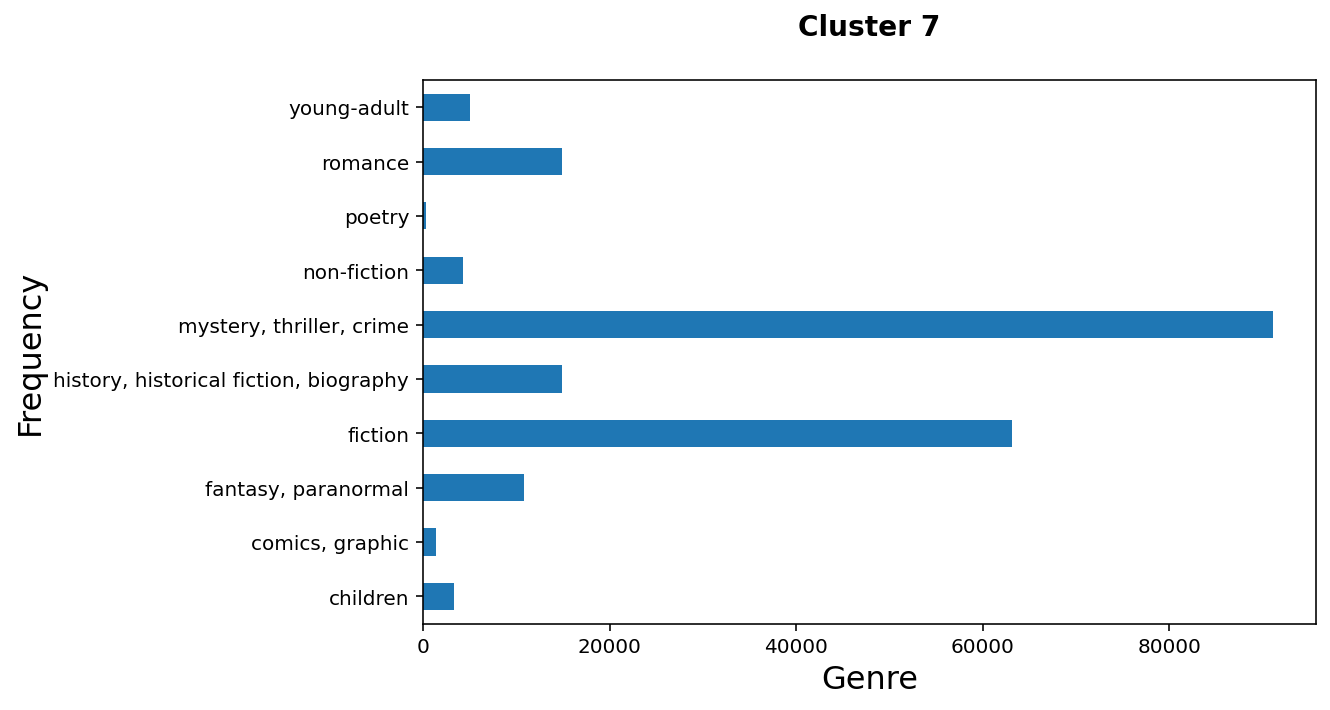

In [21]:
cluster7 = genrebook_interactions[genrebook_interactions.cluster == 7]
cluster7_plot = cluster7.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster7_plot.count(), 'barh', "Cluster 7", "Genre", "Frequency")

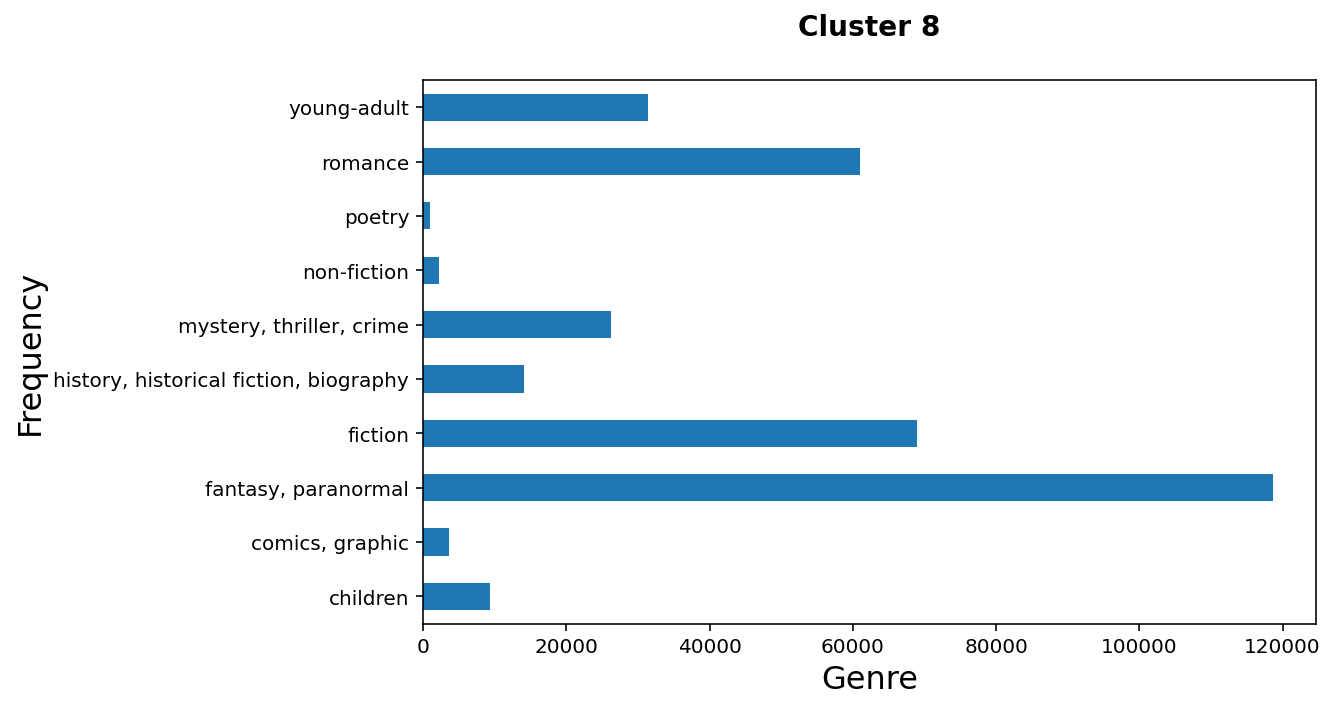

In [22]:
cluster8 = genrebook_interactions[genrebook_interactions.cluster == 8]
cluster8_plot = cluster8.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster8_plot.count(), 'barh', "Cluster 8", "Genre", "Frequency")

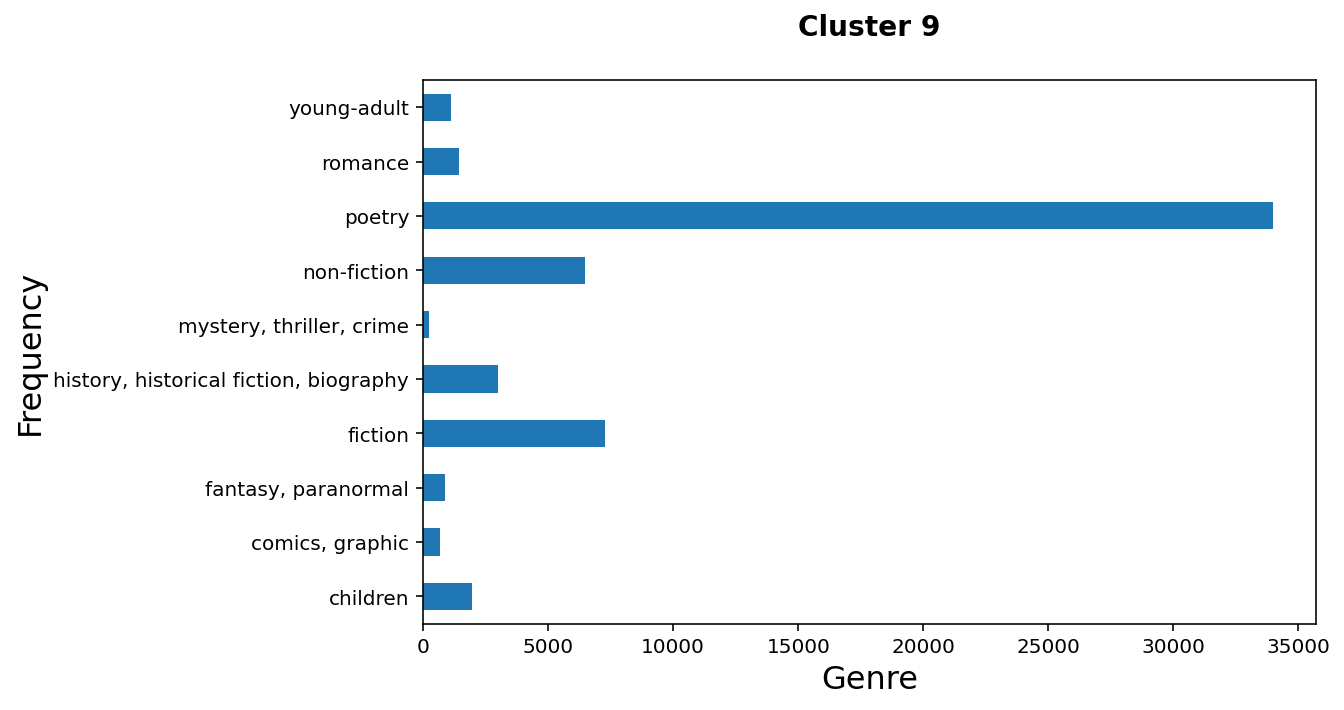

In [23]:
cluster9 = genrebook_interactions[genrebook_interactions.cluster == 9]
cluster9_plot = cluster9.replace(0,np.nan).drop(["cluster"], axis= 1)
dataframe_plot(cluster9_plot.count(), 'barh', "Cluster 9", "Genre", "Frequency")

**Analysis: With the use of k-means clustering, the books are clustered according to similar genres.**

The book are clustered mainly according to as followed:-
* Cluster 0 - Non-fiction and history/historical fiction/biography genre
* Cluster 1 - Fiction genre
* Cluster 2 - Romance, and fiction genre
* Cluster 3 - Young adult genre
* Cluster 4 - Children genre
* Cluster 5 - Comics, graphic genre
* Cluster 6 - Non-fiction genre
* Cluster 7 - Mystery/thriller/crime and fiction genre
* Cluster 8 - Fantasy/paranormal genre
* Cluster 9 - Poetry genre

## 8.5 Perform Collaborative Filtering on the dataset after k-means clustering

### 8.5.1 Integrate the clustering results to user-book interactions dataframe and select a cluster

In [24]:
#Verify Dimensions for userbook interactions
print('Userbook interactions shape is : ', userbook_interactions.shape)
print('Userbook interactions number of unique user_id: ', userbook_interactions.user_id.nunique())
print('Userbook interactions number of unique work_id: ', userbook_interactions.work_id.nunique())

Userbook interactions shape is :  (103982813, 3)
Userbook interactions number of unique user_id:  816368
Userbook interactions number of unique work_id:  1500100


In [25]:
# Integrate with user-book interactions and select cluster 0
genre_clusters = genrebook_interactions.reset_index()[["work_id", "cluster"]]
userbook_interactions = pd.merge(userbook_interactions, genre_clusters, on = "work_id", how = "left")
cluster_df = userbook_interactions[userbook_interactions.cluster == 0].drop(["cluster"], axis = 1)
cluster_df = cluster_df.reset_index(drop = True)

In [26]:
#Verify Dimensions for cluster 0
print('cluster 0: ', cluster_df.shape)
print('cluster 0 number of unique user_id: ', cluster_df.user_id.nunique())
print('cluster 0 number of unique work_id: ', cluster_df.work_id.nunique())

cluster 0:  (3349026, 3)
cluster 0 number of unique user_id:  478280
cluster 0 number of unique work_id:  127366


### 8.5.2 Defining scope of cluster dataset

Due to computational limitation, we will apply the following threshold and obtain a subset fraction of the full dataset:-
1. Threshold for ratings of a book required
2. Threshold for number of books rated by a user

### 8.5.2.1 Threshold for number of ratings for a book required

In [27]:
# Rating count for each book
cluster_ratingcount = cluster_df.groupby("work_id")["rating"].size().reset_index().rename({"rating":"ratingcount"}, axis = 1)
print(f'The top 10% of the books has a minimum rating of {cluster_ratingcount.quantile(0.90)["ratingcount"]}')
cluster_ratingcount.describe()

The top 10% of the books has a minimum rating of 34.0


,work_id,ratingcount
count,1.273660e+05,127366.000000
mean,1.404766e+07,26.294506
std,1.679434e+07,530.164156
min,1.720000e+02,1.000000
25%,1.076827e+06,2.000000
50%,5.011036e+06,4.000000
75%,2.193326e+07,11.000000
max,5.835383e+07,128340.000000


In [28]:
# Calculate the unique books of the books
cluster_df = pd.merge(cluster_df, cluster_ratingcount, on = "work_id", how = 'left')
print("The number of unique work_id that has a minimum rating of 34")
cluster_df[cluster_df.ratingcount>=34].work_id.nunique()

The number of unique work_id that has a minimum rating of 34


12919

In [29]:
# Applying the threshold of unique books
cluster_df = cluster_df[cluster_df.ratingcount>=34]

### 8.5.2.2 Threshold for number of books rated by a user

In [30]:
cluster_bookcount = cluster_df.groupby("user_id").size().reset_index().rename({0:"bookcount_peruser"}, axis = 1)
cluster_bookcount.describe()

,user_id,bookcount_peruser
count,457746.000000,457746.000000
mean,356773.189813,5.768795
std,239145.810160,12.398641
min,0.000000,1.000000
25%,158674.250000,1.000000
50%,323214.500000,3.000000
75%,521898.750000,6.000000
max,876144.000000,1187.000000


In [31]:
# Calculate the unique users that have rated at least 5 books
print("The number of unique user_id that has rated at least 5 books is")
cluster_df = pd.merge(cluster_df, cluster_bookcount, on = "user_id", how = 'left')
cluster_df[cluster_df.bookcount_peruser>=5].user_id.nunique()

The number of unique user_id that has rated at least 5 books is


143347

In [32]:
cluster_df = cluster_df[cluster_df.bookcount_peruser>=5]
cluster_df = cluster_df.drop(["bookcount_peruser", "ratingcount"], axis = 1)

In [33]:
print('cluster 0: ', cluster_df.shape)
print('cluster 0 number of unique user_id: ', cluster_df.user_id.nunique())
print('cluster 0 number of unique work_id: ', cluster_df.work_id.nunique())

cluster 0:  (2037130, 3)
cluster 0 number of unique user_id:  143347
cluster 0 number of unique work_id:  12919


To reduce the memory overload, we have round down the average ratings and imply a stricter criteria to select books that a user like.

In [34]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2037130 entries, 0 to 2640642
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int64  
 1   work_id  int64  
 2   rating   float64
dtypes: float64(1), int64(2)
memory usage: 62.2 MB


In [35]:
# To round down the average rating and change the dtype to int
cluster_df["rating"] = np.floor(cluster_df.rating)
cluster_df.rating = cluster_df.rating.astype(int)
cluster_df.rating.unique()

array([4, 5, 2, 3, 1])

In [36]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2037130 entries, 0 to 2640642
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   work_id  int64
 2   rating   int32
dtypes: int32(1), int64(2)
memory usage: 54.4 MB


### 8.5.2.3 A subset fraction of the full dataset

In [37]:
# Sample a fraction of cluster 0 
cluster_df_sample = cluster_df.sample(frac=0.2, random_state= 39)

A threshold of minimum 5 books rated by each user and the books have been rated at least 5 times is placed to ensure there is sufficient user book interactions when performing train-test-split.

#### 8.5.2.3.1 Threshold for users rating a book

In [38]:
print('cluster 0: ', cluster_df_sample.shape)
print('cluster 0 number of unique user_id: ', cluster_df_sample.user_id.nunique())
print('cluster 0 number of unique work_id: ', cluster_df_sample.work_id.nunique())

cluster 0:  (407426, 3)
cluster 0 number of unique user_id:  121692
cluster 0 number of unique work_id:  12910


In [39]:
cluster_ratingcount = cluster_df_sample.groupby("work_id")["rating"].size().reset_index().rename({"rating":"ratingcount"}, axis = 1)
cluster_ratingcount.describe()

,work_id,ratingcount
count,1.291000e+04,12910.000000
mean,1.012185e+07,31.558947
std,1.411975e+07,159.992981
min,1.720000e+02,1.000000
25%,5.301040e+05,8.000000
50%,2.342903e+06,12.000000
75%,1.627674e+07,24.000000
max,5.835383e+07,10801.000000


In [40]:
# Calculate the unique books of the books
cluster_df_sample = pd.merge(cluster_df_sample, cluster_ratingcount, on = "work_id", how = 'left')
print("The number of unique books after applying this threshold is")
cluster_df_sample[cluster_df_sample.ratingcount>=5].work_id.nunique()

The number of unique books after applying this threshold is


12046

In [41]:
# Applying the threshold on the subset of sample
cluster_df_sample = cluster_df_sample[cluster_df_sample.ratingcount>=5]

#### 8.5.2.3.2 Threshold for number of books rated by a user

In [42]:
cluster_bookcount = cluster_df_sample.groupby("user_id").size().reset_index().rename({0:"bookcount_peruser"}, axis = 1)
cluster_bookcount.describe()

,user_id,bookcount_peruser
count,121412.000000,121412.000000
mean,265164.443926,3.332282
std,188279.450374,4.353433
min,0.000000,1.000000
25%,113582.750000,1.000000
50%,243901.000000,2.000000
75%,382259.250000,4.000000
max,876137.000000,240.000000


In [43]:
cluster_df_sample = pd.merge(cluster_df_sample, cluster_bookcount, on = "user_id", how = 'left')
print("The number of unique users after applying this threshold is")
cluster_df_sample[cluster_df_sample.bookcount_peruser>=5].user_id.nunique()

The number of unique users after applying this threshold is


22749

In [44]:
cluster_df_sample = cluster_df_sample[cluster_df_sample.bookcount_peruser>=5]
cluster_df_sample = cluster_df_sample.drop(["bookcount_peruser", "ratingcount"], axis = 1)

In [45]:
print('cluster 0: ', cluster_df_sample.shape)
print('cluster 0 number of unique user_id: ', cluster_df_sample.user_id.nunique())
print('cluster 0 number of unique work_id: ', cluster_df_sample.work_id.nunique())

cluster 0:  (203576, 3)
cluster 0 number of unique user_id:  22749
cluster 0 number of unique work_id:  11903


### 8.5.3 Split the data into train/test data

In [46]:
train, test = train_test_split(cluster_df_sample, test_size = 0.25, random_state = 39, stratify = cluster_df_sample["user_id"])

In [47]:
#Verify Dimensions
print('train: ', train.shape)
print('test: ', test.shape)
print('train number of unique user_id: ', train.user_id.nunique())
print('test number of unique user_id: ', test.user_id.nunique())

train:  (152682, 3)
test:  (50894, 3)
train number of unique user_id:  22749
test number of unique user_id:  22749


In [48]:
print(f"The presence of train user_id in test: {train.user_id.isin(test.user_id).value_counts()}")
print(f"The presence of train work_id in test: {train.work_id.isin(test.work_id).value_counts()}")

The presence of train user_id in test: True    152682
Name: user_id, dtype: int64
The presence of train work_id in test: True     144615
False      8067
Name: work_id, dtype: int64


In [49]:
print(f"The presence of test user_id in train: {test.user_id.isin(train.user_id).value_counts()}")
print(f"The presence of test work_id in train: {test.work_id.isin(train.work_id).value_counts()}")

The presence of test user_id in train: True    50894
Name: user_id, dtype: int64
The presence of test work_id in train: True     50698
False      196
Name: work_id, dtype: int64


In [50]:
# To transfer the test work_id not present in train to train set
test["presence"] = test.work_id.isin(train.work_id).astype(int)
test_notpresent = test[test["presence"] == 0]
test = test[test.presence == 1]
test_notpresent = test_notpresent.drop(["presence"], axis = 1)
test = test.drop(["presence"], axis = 1)
train = pd.concat([train, test_notpresent], axis = 0)

# Reset the index for train and test set
train = train.sort_values(by="user_id").reset_index(drop=True)
test = test.sort_values(by="user_id").reset_index(drop=True)

print(f"The train set shape is {train.shape}")

The train set shape is (152878, 3)


<ipython-input-50-ddec719f1588>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["presence"] = test.work_id.isin(train.work_id).astype(int)


In [51]:
print(f"The presence of test user_id in train: {test.user_id.isin(train.user_id).value_counts()}")
print(f"The presence of test work_id in train: {test.work_id.isin(train.work_id).value_counts()}")

The presence of test user_id in train: True    50698
Name: user_id, dtype: int64
The presence of test work_id in train: True    50698
Name: work_id, dtype: int64


### 8.5.4 Collaborative filtering - user-based

In [52]:
# Form the pivot table and mean-centralised the ratings per user
user_rating = pd.pivot_table(train, index = "user_id", columns = "work_id", values = "rating")
user_mean_centering = (user_rating.T - user_rating.mean(axis = 1)).T
user_mean_centering = user_mean_centering.fillna(0)
# Cosine similarity of the users
similarity_matrix = cosine_similarity(user_mean_centering)
similar_users = pd.DataFrame(similarity_matrix, columns=user_mean_centering.index, index=user_mean_centering.index)

In [53]:
for index, value in enumerate(test.user_id):
    userid_query = value
    workid_query = test.work_id[index]
    test.loc[[index], ["predicted_rating_user"]] = user_collaborative_filtering_cosine(user_rating, similar_users, userid_query, workid_query)
    clear_output(wait=True)
    print(f'progress: {index+1}/{len(test.user_id)}')

progress: 50698/50698


In [54]:
test_coverage = coverage(test, "predicted_rating_user")
test_coverage

The total observations: 50698
Unable to predict:(22826, 4)
Able to predict:(27872, 4)

The coverage for the recommender system is


54.98

In [55]:
rmse = ratings_rmse(test, "rating", "predicted_rating_user")
rmse

1.0885891162473784

**Analysis: User-based collaborative filtering has an RMSE of 1.0886 with a coverage of 54.98%.** 

The user-based collaborative filtering has a RMSE that is lower than the baseline model, which suggests that the recommender system is able to perform some prediction. However, it has a moderate coverage that could possibly due to the inability to find similar users, or similar users have not read the book in query.

### 8.5.5 Collaborative filtering - item-based

In [56]:
user_book_rating = pd.pivot_table(train, index = "user_id", columns = "work_id", values = "rating")
user_book_rating_mean = (user_book_rating - user_book_rating.mean(axis=0)).T.fillna(0)
sim_matrix = cosine_similarity(user_book_rating_mean)
movies_sim = pd.DataFrame(sim_matrix, columns=user_book_rating_mean.index, index=user_book_rating_mean.index)

In [57]:
for index, value in enumerate(test.user_id):
    userid_query = value
    workid_query = test.work_id[index]
    result = item_collaborative_filtering_cosine(user_book_rating, movies_sim, userid_query, workid_query)
    test.loc[[index], ["predicted_rating_item"]] = result
    clear_output(wait=True)
    print(f'progress: {index+1}/{len(test.user_id)}')

progress: 50698/50698


In [58]:
test_coverage = coverage(test, "predicted_rating_item")
test_coverage

The total observations: 50698
Unable to predict:(21084, 5)
Able to predict:(29614, 5)

The coverage for the recommender system is


58.41

In [59]:
rmse = ratings_rmse(test, "rating", "predicted_rating_item")
rmse

1.0453884865297929

**Analysis: Item-based collaborative filtering has an RMSE of 1.0454 with a coverage of 58.41%.** 

The item-based collaborative filtering has a RMSE that is lower than the baseline model and performs slightly better than user-based collaborative filtering. This is because item-based collaborative filtering is based on items, which are fixed rather than user-based, which can varies with the presence of similar users and the user preference. However, it also has a moderate coverage of 58.41%, which could possibly due to the inability to find similar items among the users, or similar items that include the book in query.

## Exporting Data

In [60]:
#Placed the # to refrain from executing
# genrebook_interactions.to_parquet("../data/genrebook_interactions_clusters.parquet", compression = 'gzip')